# Analysis

In [2]:
import pandas as pd




"""
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

from tqdm.notebook import tqdm 
"""

'\nimport numpy as np\nfrom scipy import stats\nimport pandas as pd\nimport matplotlib.pylab as plt\nimport seaborn as sns\nfrom matplotlib_venn import venn2, venn3\n\nfrom tqdm.notebook import tqdm \n'

In [3]:
papers_df = pd.read_json('../data/papers_FOCS_ICML_NIPS_STOC_2000_2009.json')
authors_df = pd.read_json('../data/authors_FOCS_ICML_NIPS_STOC_2000_2009.json')

In [7]:
papers_df = pd.concat([retrive_conf_papers(conf.lower(), year)
                       for conf in tqdm(CONF2COMMUNITY)
                       for year in YEAR_RANGE])

papers_df = papers_df.drop(DROP_COLS, axis=1)


Missing authors (nips, 2016):  3
Missing authors (nips, 2017):  2



## Community, Venue and Year

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


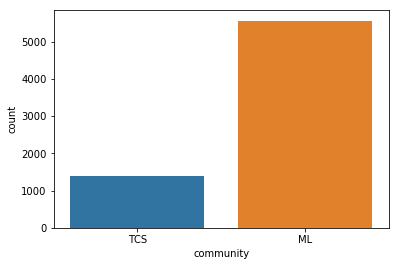

In [11]:
sns.countplot(papers_df['community'])

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


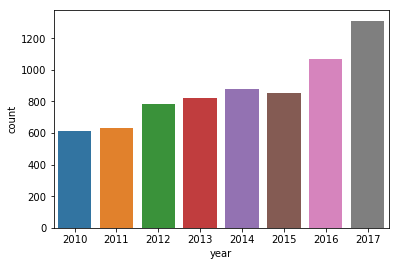

In [12]:
sns.countplot(papers_df['year'])

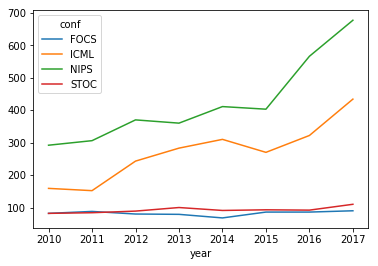

In [13]:
papers_df.groupby(['conf', 'year']).size().unstack().T.plot()

## Number of Authors

/Users/shlomi/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


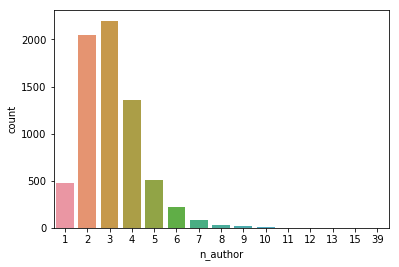

In [23]:
sns.countplot(papers_df['n_author'])

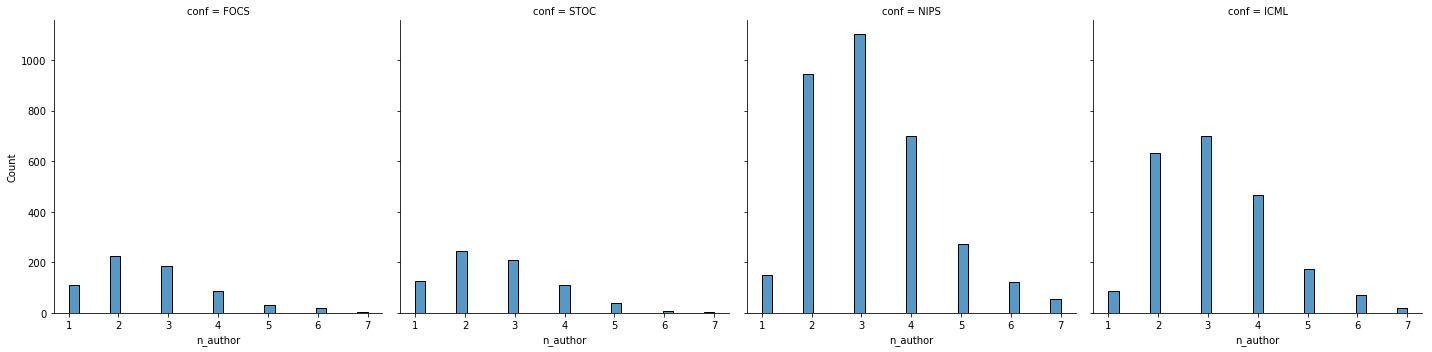

In [32]:
sns.displot(x='n_author', col='conf', kind="hist", data=papers_df[papers_df['n_author'] < 8])

In [67]:
n_author_per_conf = ((papers_df.groupby('conf')['n_author']
                      .value_counts(normalize=True)
                      .unstack()
                      .T
                      .fillna(0)
                      .round(3) * 100))

In [68]:
n_author_per_conf

conf,FOCS,ICML,NIPS,STOC
n_author,,,,
1,16.5,4.0,4.4,16.9
2,34.0,29.1,27.9,33.1
3,28.2,32.3,32.6,28.1
4,13.1,21.4,20.7,14.8
5,4.6,7.9,8.0,5.4
6,2.9,3.2,3.6,1.1
7,0.5,0.9,1.6,0.4
8,0.2,0.5,0.6,0.3
9,0.0,0.3,0.2,0.0


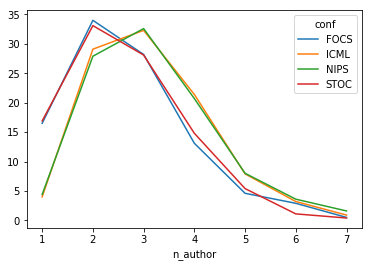

In [70]:
n_author_per_conf[n_author_per_conf.index < 8].plot()

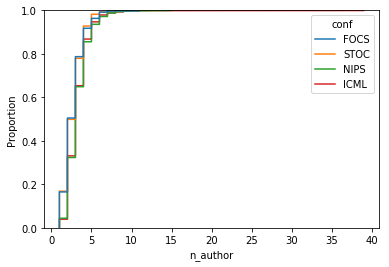

In [33]:
sns.ecdfplot(x='n_author', hue='conf', data=papers_df)

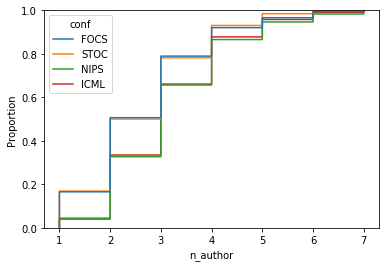

In [35]:
sns.ecdfplot(x='n_author', hue='conf', data=papers_df[papers_df['n_author'] < 8])

In [48]:
from scipy.stats import ks_2samp

ks_2samp(papers_df[papers_df['community'] == 'TCS']['n_author'],
         papers_df[papers_df['community'] == 'ML']['n_author'])

KstestResult(statistic=0.17540662108672184, pvalue=2.3314683517128287e-15)

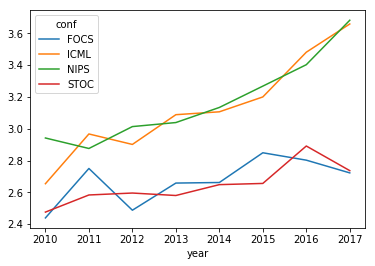

In [38]:
(papers_df
 .groupby(['conf', 'year'])['n_author'].mean()
 .unstack().T.plot())

## Alphabetic Order

In [130]:
papers_df.groupby('community')['is_alphabetical'].mean()

community
ML     0.320259
TCS    0.970000
Name: is_alphabetical, dtype: float64

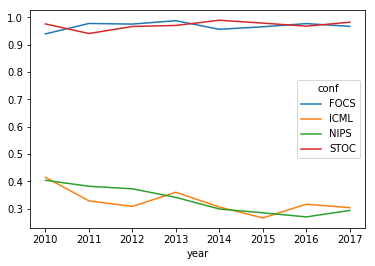

In [58]:
papers_df.groupby(['conf', 'year'])['is_alphabetical'].mean().unstack().T.plot()

## Authors 

In [180]:
def unify_author(authors):
    return set.union(*map(set, authors))

all_authors = unify_author(papers_df['author'])

len(all_authors)

8733

### TCS vs. ML communities

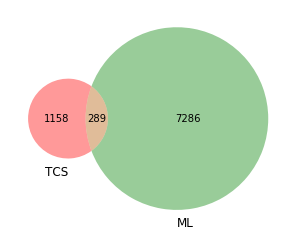

In [98]:
TCS_authors = unify_author(papers_df[papers_df['community'] == 'TCS']['author'])
ML_authors = unify_author(papers_df[papers_df['community'] == 'ML']['author'])

venn2([TCS_authors, ML_authors], ['TCS', 'ML']);

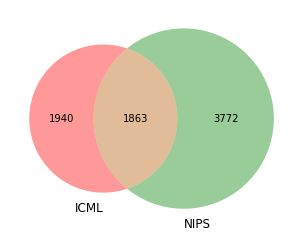

In [99]:
ICML_authors = unify_author(papers_df[papers_df['conf'] == 'ICML']['author'])
NIPS_authors = unify_author(papers_df[papers_df['conf'] == 'NIPS']['author'])

venn2([ICML_authors, NIPS_authors], ['ICML', 'NIPS']);

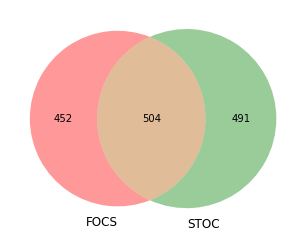

In [102]:
FOCS_authors = unify_author(papers_df[papers_df['conf'] == 'FOCS']['author'])
STOC_authors = unify_author(papers_df[papers_df['conf'] == 'STOC']['author'])

venn2([FOCS_authors, STOC_authors], ['FOCS', 'STOC']);

### Adopting alphabetical order

In [156]:
def community_is_alphabetical_by_authors(authors):
    return (papers_df[papers_df['author']
     .apply(lambda r: any(author in authors for author in r))]
     .groupby('community')['is_alphabetical']
     .mean())

In [413]:
common_authors = TCS_authors & ML_authors

assert all_authors == (TCS_authors-common_authors) | (ML_authors-common_authors) | common_authors

community_is_alphabetical_by_authors(common_authors)

community
ML     0.501389
TCS    0.968603
Name: is_alphabetical, dtype: float64

In [283]:
comm_assignment = {}

for author in common_authors:
    count = Counter(papers_df[papers_df['author'].apply(lambda r: author in r)]['community'])
    comm_assignment[author] = count['ML'] / count['TCS']
    
comm_assignment = pd.Series(comm_assignment)

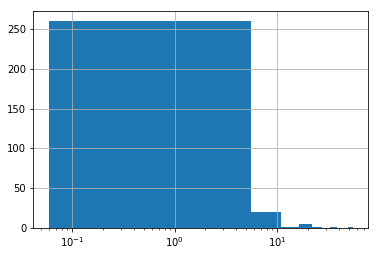

In [286]:
ax = comm_assignment.hist()
ax.set_xscale('log')

In [174]:
TCS_common_authors = set((comm_assignment[comm_assignment <= 1/2]).index)
ML_common_authors = set((comm_assignment[comm_assignment >= 2]).index)

len(TCS_common_authors), len(ML_common_authors)

(105, 92)

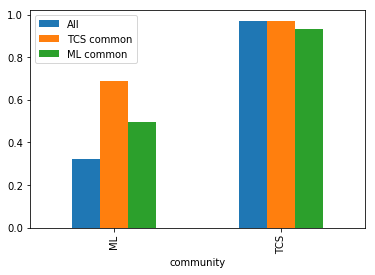

In [179]:
pd.DataFrame({'All': papers_df.groupby('community')['is_alphabetical'].mean(),
              'TCS common': community_is_alphabetical_by_authors(TCS_common_authors),
              'ML common': community_is_alphabetical_by_authors(ML_common_authors)}).plot(kind='bar')

## Authors data

https://github.com/scholarly-python-package/scholarly

In [212]:
import time

from scholarly import scholarly

In [215]:
if False:
    results = {}
    for author_name in tqdm(all_authors):
        search_query = scholarly.search_author(author_name)
        try:
            author = next(search_query)
        except StopIteration:
            print(author_name)
            continue

        results[author_name] = author.fill(['indices', 'counts'])

        time.sleep(0.5)

Dvir Falik
Michael J. Wilber
Beresford N. Parlett
Iftah Gamzu
Yuval Harel
Mattias Gybels
Brody Huval
Vivek F. Farias
Peter B. Jones
Raymond J. Mooney
Matthew B. Blaschko
Ness B. Shroff
Andrew An Bian
Alice H. Oh
Jouni Hartikainen
Nicol{\&apos;{a}}s Della Penna
Marco F. Cusumano{-}Towner
Douglas H. Roossien
Georges A. Goetz
Dirk Husmeier
Helmut B{\&quot;{o}}lcskei
Christoph Berkholz
Subhashini Krishnasamy
Siqiang Wen
Harish Karnick
Chen{-}Kuei Lee
Hung Hai Bui
David M. Budden
Eui Chul Richard Shin
Vahab S. Mirrokni
Miguel {\&apos;{A}}ngel Bautista
Olivier Can{\&apos;{e}}vet
Dietmar Ebner
M{\&apos;{a}}ty{\&apos;{a}}s Brendel
Andreas Stuhlm{\&quot;{u}}ller
Tsuyoshi Ueno
Susan A. Murphy
Amirmohammad Rooshenas
Shiau Hong Lim
Bert Kappen
Karen E. Blackmon
Omer Gim{\&apos;{e}}nez
Mamadou Thiao
Purushottam Kar
Cl{\&apos;{e}}ment Farabet
Sergey M. Plis
Katja Seeliger
Brendan van Rooyen
Jos{\&apos;{e}} M. F. Moura
Hsiao{-}Wei Tung
Alexander J. Smola
Avleen Singh Bijral
William R. Carson
Paramesw

G{\&quot;{u}}nter Klambauer
Kristof Sch{\&quot;{u}}tt
Martin A. Riedmiller
Pannagadatta K. Shivaswamy
Silvio Micali
Steven de Rooij
Aapo Hyv{\&quot;{a}}rinen
Shahar Chen
Jakub W. Pachocki
Qinyuan Sun
Hoyt A. Koepke
David K. Gifford
Pawan Kumar Mudigonda
Guillermo D. Ca{\~{n}}as
Gerasimos Palaiopanos
Zhixun Su
Fran{\c{c}}ois Pachet
Julie A. Shah
Bal{\&apos;{a}}zs Sz{\&quot;{o}}r{\&apos;{e}}nyi
Naresh R. Shanbhag
Hanlin Xue
Avishai Wagner
Kyle R. Ulrich
William T. Stephenson
Ronny Lempel
Eleni Sgouritsa
Boris Lesner
Lu{\&apos;{\i}}s Paulo Reis
Bal{\&apos;{a}}zs K{\&apos;{e}}gl
Salomon Diether
Mingrui Wu
Manas A. Pathak
Charles A. Micchelli
Lilyana Mihalkova
Maren Westkott
Thomas P. Parnell
Junichiro Hirayama
Urs K{\&quot;{o}}ster
Shiva Prasad Kasiviswanathan
Guillaume Malod
Eldar Fischer
Andrzej Truski
Ramesh Hariharan
Katja Hansen
Thomas G. Dietterich
Ashish Chiplunkar
Rolando D. Somma
Peter J. Bickel
Benedict J. Leimkuhler
Martin Both
Abram L. Friesen
Stephen P. Boyd
Christoph D. Hofer

Markus S. Dregi
Justin T. Khim
L. Elisa Celis
Gunnar Kedenburg
Minwei Ye
Alim Virani
Andrei B. Ungureanu
G{\&apos;{e}}rard G. Medioni
Peggy L. Peissig
Gonzalo Mart{\&apos;{\i}}nez{-}Mu{\~{n}}oz
Ann B. Ragin
Georges H{\&apos;{e}}brail
Naftali Tishby
Sven Kurras
Christopher James Langmead
Stefan R{\&quot;{u}}ping
Guangyun Chen
Kritika Muralidharan
Xue{-}Min Si
Sinong Geng
Rocco A. Servedio
Tatsunori B. Hashimoto
Hangen He
Clark Glymour
Jop Bri{\&quot;{e}}t
Sina Sadeghian Sadeghabad
Lester W. Mackey
David M. Blei
Niklas Wahlstr{\&quot;{o}}m
John P. Cunningham
Rapha{\&quot;{e}}l Fonteneau
Jessica A. Grahn
Gr{\&apos;{e}}gory Rogez
Shinya Suzumura
Andr{\&apos;{a}}s Gy{\&quot;{o}}rgy
Rafael da Ponte Barbosa
Rafael G{\&apos;{o}}mez{-}Bombarelli
Jeshua Bratman
S. Jalil Kazemitabar
Hanna M. Wallach
Peter B. Reich
John G. Oberlin
Jonathan S. Yedidia
Suresh K. Bhavnani
John V. Guttag
Till Tantau
Alan M. Frieze
Eyke H{\&quot;{u}}llermeier
Julien Rivaud
Ram{\&apos;{o}}n Sagarna
Ranganath Kondapally


Andr{\&apos;{e}} Chailloux
Hastagiri P. Vanchinathan
Gaute T. Einevoll
Christoph Schn{\&quot;{o}}rr
Abhiram Natarajan
William Austin Webb
Chris Barber
Daisuke Hatano
Dario Garc{\&apos;{\i}}a{-}Garc{\&apos;{\i}}a
Micha{\&quot;{e}}l Mathieu
Sven J. Dickinson
Jacquelyn A. Shelton
Chip Schaff
Grani Adiwena Hanasusanto
Paul Lagr{\&apos;{e}}e
Felipe Llinares{-}L{\&apos;{o}}pez
Zuoguan Wang
Kirk Goldsberry
Trevor D. Wooley
David A. Sontag
{\c{C}}aglar G{\&quot;{u}}l{\c{c}}ehre
Yariv Dror Mizrahi
Elie Bienenstock
Jes{\&apos;{u}}s Cerquides
Alyssa Shofner
Sahand N. Negahban
Thomas Rothvo{\ss}
Zane T. Smith
Jack W. Rae
Evangelos A. Theodorou
Fran{\c{c}}ois Charpillet
Zdenek Dvor{\&apos;{a}}k
Sylvain Perifel
Jake V. Bouvrie
Jonah Sherman
Daniel J. Hsu
Nihar Bhadresh Shah
Hiroshi Mamitsuka
Toke Jansen Hansen
Richard D. Lawrence
Fran{\c{c}}ois Duport
Mattias H{\&quot;{o}}glund
Fabian L. Wauthier
Bryan R. Gibson
Kirsten Eisentr{\&quot;{a}}ger
Pushkar S. Joglekar
Henner Schmidt
Laurent Massouli{\&apo

Andreas Gr{\&quot;{u}}bl
Clay J. Stanek
Stephen J. Dilworth
Trevor J. Hastie
David Meierfrankenfeld
Shabnam N. Kadir
Joshua R. Loftus
Sami Naamane
Jun'ichi Takeuchi
Shun Liao
Snigdhansu Chatterjee
Jakub Gajarsk{\&apos;{y}}
Felix V. Agakov
Bernardo {\&apos;{A}}vila Pires
J. D. Tygar
Charles M. Gaona
Arild N{\o}kland
Matthias S. Keil
Ian B. Ross
Stephen I. Ryu
David Szepesvari
Lubomir D. Bourdev
James Ze Wang
Jes{\&apos;{u}}s Cid{-}Sueiro
Timothy N. Rubin
Mark Z. Mao
Pooria Joulani
Daniel A. Spielman
Demba E. Ba
Marthinus Christoffel du Plessis
Al{\&apos;{a}}n Aspuru{-}Guzik
Andrew E. Loeb
Jing{-}Cheng Shi
Yurii E. Nesterov
Yuanbin Wu
Kieran Milan
Peter Richt{\&apos;{a}}rik
Suprovat Ghoshal
Fr{\&apos;{e}}d{\&apos;{e}}ric Magniez
Chengtao Li
Ryan C. Williamson
Eduard H. Hovy
Aleksandr Y. Aravkin
J. Anthony Movshon
Alberto Garc{\&apos;{\i}}a{-}Dur{\&apos;{a}}n
Ameet S. Talwalkar
Jingliang Bai
Andrew E. Waters
Gert R. G. Lanckriet
Frank Thomson Leighton
Andy Schuetz
Bhargav Avasarala
Peter 

In [218]:
len(results)/len(all_authors)


0.7789991984426886

TODO:
dist of first letter & dist of community - compare missing and existing, check who are the missing by community and year!!!!!!

In [240]:
results['Shichao Yue']

{'affiliation': 'MIT',
 'citedby': 221,
 'citedby5y': 221,
 'cites_per_year': {2017: 6, 2018: 45, 2019: 71, 2020: 99},
 'email': '@mit.edu',
 'filled': False,
 'hindex': 5,
 'hindex5y': 5,
 'i10index': 4,
 'i10index5y': 4,
 'id': 'NmGT2o8AAAAJ',
 'interests': ['Wireless Sensing', 'Applied Machine Learning', 'Healthcare'],
 'name': 'Shichao Yue',
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=NmGT2o8AAAAJ'}

In [663]:
import string

from statsmodels.distributions.empirical_distribution import ECDF


AUTHOR_FIELDS = ['affiliation', 'citedby', 'citedby5y', 'cites_per_year', 'email',
                 'hindex', 'hindex5y','i10index', 'i10index5y', 'id', 'interests','name', 'url_picture']

authors_df = (pd.DataFrame([{field: getattr(author, field)
                            for field in AUTHOR_FIELDS if hasattr(author, field)}
              for author in results.values()])
              .rename({'name': 'full_name'}, axis=1))

authors_df.index = list(results.keys())
authors_df[['citedby', 'citedby5y']] = authors_df[['citedby', 'citedby5y']].fillna(0)

authors_df['scientific_age'] = authors_df['cites_per_year'].apply(lambda r: 2021 - min(r.keys()) if r else 0) + 1

authors_df['stand_author'] = authors_df.index.map(standaraize_author_name)
authors_df['letter'] = authors_df['stand_author'].str[0].str[0]
authors_df['letter_int'] = authors_df['letter'].apply(string.ascii_uppercase.index)
letter_ecdf = ECDF(authors_df['letter_int'])
authors_df['letter_val'] = authors_df['letter_int'].apply(letter_ecdf)


def which_community(name):
    if name in common_authors:
        return 'COMMON'
    elif name in TCS_authors:
        return 'TCS'
    elif name in ML_authors:
        return 'ML'
    else:
        print(name)
        raise ValueError()

        
authors_df['community'] = authors_df.index.map(which_community)

authors_df['stand_author'] = authors_df.index.map(standaraize_author_name)
authors_df['letter'] = authors_df['stand_author'].str[0].str[0]
authors_df['letter_int'] = authors_df['letter'].apply(string.ascii_uppercase.index)
letter_ecdf = ECDF(authors_df['letter_int'])
authors_df['letter_val'] = authors_df['letter_int'].apply(letter_ecdf)

In [664]:
authors_df[(authors_df['stand_author'].str[0].str[0] == 'd')]

,affiliation,citedby,citedby5y,cites_per_year,email,hindex,hindex5y,i10index,i10index5y,id,interests,full_name,url_picture,scientific_age,stand_author,letter,letter_int,letter_val,community


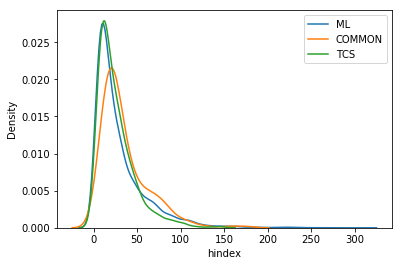

In [665]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='hindex', label=label)
plt.legend()

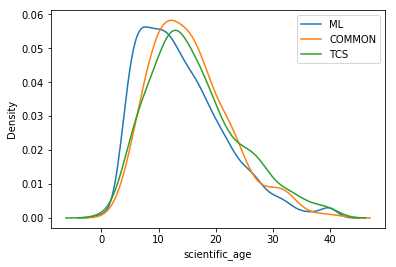

In [666]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    sns.kdeplot(data=community_df, x='scientific_age', label=label)
plt.legend()

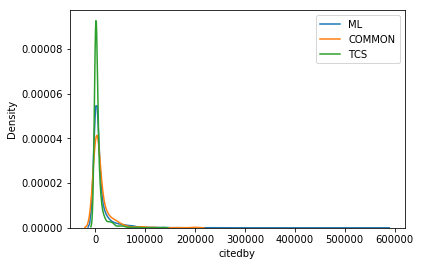

In [667]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    ax = sns.kdeplot(data=community_df, x='citedby', label=label)
    # ax.set_xscale('log')
plt.legend()

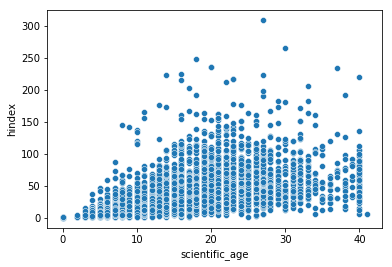

In [668]:
ax = sns.scatterplot(x='scientific_age', y='hindex', data=authors_df)

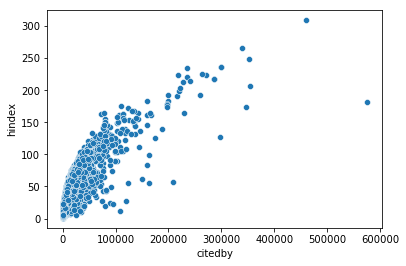

In [669]:
ax = sns.scatterplot(x='citedby', y='hindex', data=authors_df)

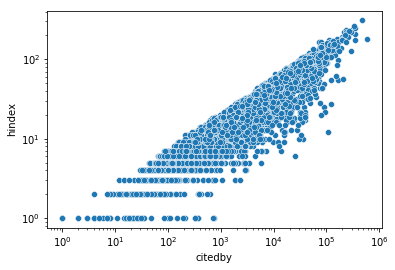

In [670]:
ax = sns.scatterplot(x='citedby', y='hindex', data=authors_df)
ax.set_xscale('log')
ax.set_yscale('log')

### Letter distribution

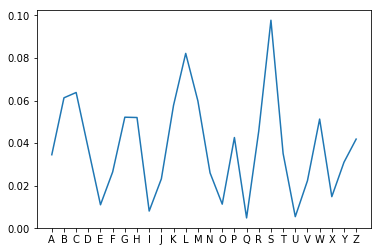

In [671]:
authors_df['letter_int'].value_counts(normalize=True).sort_index().plot()
plt.xticks(range(26), string.ascii_uppercase);

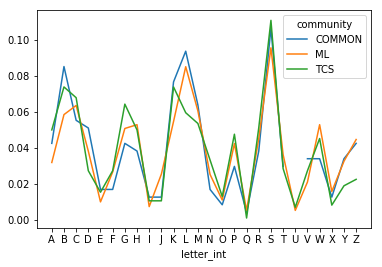

In [672]:
authors_df.groupby('community')['letter_int'].value_counts(normalize=True).unstack().T.plot()
plt.xticks(range(26), string.ascii_uppercase);

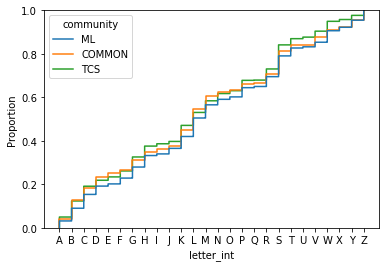

In [673]:
sns.ecdfplot(x='letter_int', hue='community', data=authors_df)
plt.xticks(range(26), string.ascii_uppercase);

In [674]:
ks_2samp(authors_df[authors_df['community'] == 'ML']['letter'],
         authors_df[authors_df['community'] == 'TCS']['letter'])

KstestResult(statistic=0.05103750997605746, pvalue=0.0423386684627407)

### Adding papers data to authors

In [675]:
from collections import defaultdict

coauthors = defaultdict(list)

for _, paper in papers_df.iterrows():
    for name in paper['author']:
        coauthors[name].append(paper['author'])
        
authors_df = pd.merge(authors_df,
                      pd.Series(coauthors, name='coauthors'),
                      how='left', left_index=True, right_index=True)

authors_df['n_pubs'] = authors_df['coauthors'].apply(len)

authors_df['stand_coauthors'] = authors_df['coauthors'].apply(lambda r: [[standaraize_author_name(a) for a in ca] for ca in r])

authors_df['avg_is_sort'] = authors_df['stand_coauthors'].apply(lambda r: np.mean([is_sorted(ca) for ca in  r]))

authors_df['only_sing'] = authors_df['coauthors'].apply(lambda r: set(map(len, r)) == {1})

def get_coauthors_letters(row):
    return [a[0][0]
            for ca in row['stand_coauthors']
            for a in ca if a != row['stand_author']]

authors_df['coauthors_letter'] = authors_df.apply(get_coauthors_letters, axis=1)

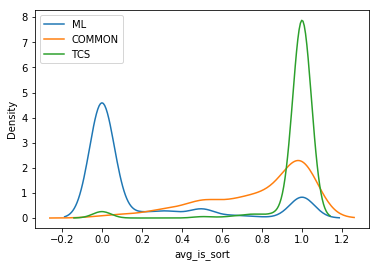

In [676]:
for label in authors_df['community'].unique():
    community_df = authors_df[authors_df['community']==label]
    ax = sns.kdeplot(data=community_df, x='avg_is_sort', label=label)
    # ax.set_xscale('log')
plt.legend()

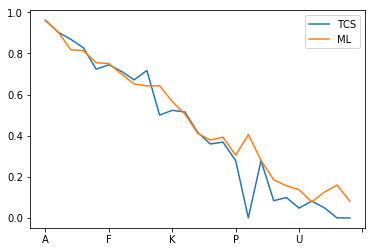

In [677]:
def conditional_author_coauthor_letter(df):
    d = defaultdict(lambda: defaultdict(int))
    for _, row in df.iterrows():
        for cal in row['coauthors_letter']:
            d[row['letter']][cal] +=  1
    
    # columns: author
    # rows: coauthor
    # so normalize per column  ca|a
    res = (pd.DataFrame(d)
           .fillna(0)
           .sort_index()
           .sort_index(axis=1))
    
    norm_res = (res / res.sum(axis=0))
    
    assert norm_res['B'].sum() == 1
    return norm_res

cond_a_ca = {community:
             conditional_author_coauthor_letter(authors_df[authors_df['community'] == community])
             for community in ['TCS', 'ML']}

cond_a_ca_latter = {}
for community, cond_letter in cond_a_ca.items():
    cond_a_ca_latter[community] = {a: cond_letter[a][ca:].sum()
                                   for a, ca in zip(string.ascii_uppercase, string.ascii_uppercase[1:])}

pd.DataFrame(cond_a_ca_latter).plot()

In [678]:
authors_df.groupby('community')['only_sing'].mean() * 100

community
COMMON    0.000000
ML        0.803073
TCS       2.619048
Name: only_sing, dtype: float64

In [679]:
authors_df['positions'] = authors_df.apply(lambda r: [(ca.index(r.name), len(ca)) for ca in r['coauthors']],
                          axis=1)


#[(ca.index(a), len(ca)) for ca in authors_df.iloc[13]['coauthors']]

In [682]:
(authors_df['first_prop'],
 authors_df['last_prop']) = (authors_df['positions'].apply(lambda pos: np.mean([ind == 0 for ind, _ in pos])),
                            authors_df['positions'].apply(lambda pos: np.mean([ind == (n_co-1) for ind, n_co in pos])))

## The real thing

TODO: Read the paper and model the experiemnt, then run it

TODO: filter by years

pick up sample, per community
correlate letter - hindex
correlate paper proportion
which reg? I'd try two

--- controls, which?

--- something about time (predict h index now based on historical sample)

In [756]:
print(authors_df['citedby'].median())

2393.0


In [862]:
import statsmodels.api as sm

print(authors_df['n_pubs'].median())

mask =  (authors_df['community'] == 'TCS') & (authors_df['n_pubs'] > 1)
print(mask.sum() / len(mask))
X = authors_df[mask][['first_prop', 'last_prop', 'letter_int']]#, 'first_prop', 'last_prop']]
X = sm.add_constant(X)
y = authors_df['annual_productivity'][mask]
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

1.0
0.05835660737909746
                             OLS Regression Results                            
Dep. Variable:     annual_productivity   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.7866
Date:                 Fri, 04 Dec 2020   Prob (F-statistic):              0.502
Time:                         16:29:06   Log-Likelihood:                -2951.9
No. Observations:                  397   AIC:                             5912.
Df Residuals:                      393   BIC:                             5928.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        276.3

In [846]:
authors_df['annual_productivity'] = authors_df['citedby'] / authors_df['scientific_age']
authors_df['annual_productivity'] = authors_df['annual_productivity'].fillna(0)

In [822]:
authors_df['annual_productivity'].isna().any()

False

In [844]:
authors_df(authors_df['cites_per_year'].apply(len) == 0) & (authors_df['citedby'] >0)

TypeError: 'DataFrame' object is not callable